# Figure 2

We want to show that mBGP assigns cell labels better than BGP.
We demonstrate this by setting branching points to true locations.
We produce a summary table and a pretty histogram


# Helper definitions

In [1]:
from MMBGP.data_generation import ToyBranchedData, GeneExpressionData
from MMBGP.training_helpers import TrainingOutcome, get_training_outcome
from MMBGP.plotting_helpers import plot_detailed_fit, plot_model_snapshot
from MMBGP.sampling_helpers import get_synthetic_noisy_branched_data

from MMBGP.assigngp import AssignGP
from MMBGP.VBHelperFunctions import plotBranchModel
import matplotlib.pyplot as plt
import numpy as np

from MMBGP.training_helpers import (
    construct_assigngp_model, 
    SimplePhiConstructor, 
    ScipyOptimiser, 
    ElvijsAmazingOptimiser,
)
import gpflow
from typing import Sequence


def get_assigngp_with_target_bps(bps: Sequence[float], lengthscale: float, noise_variance: float) -> AssignGP:
    """ A simple wrapper that tweaks some key model construction parameters. """
    data = ToyBranchedData(bps, N=100)  # not used; need data to construct a model
    m = construct_assigngp_model(
        gene_expression=data,
        phi_constructor=SimplePhiConstructor(data, prior_confidence=0.65),
        initial_branching_points=[0.5]*data.num_genes,
    )
    
    # assign reasonable initial values for the BPs
    m.kernel.Bv.assign(np.array(bps))
    m.kernel.kern.lengthscales.assign(lengthscale)
    m.likelihood.variance.assign(noise_variance)
    return m

In [2]:
from MMBGP.data_generation import Vector
from MMBGP.training_helpers import InitialAndPriorPhi, PhiConstructor


def get_funky_phi(
        global_branching_state: Vector,
        uninformative_until: float,
        informative_prior_confidence: float,
) -> InitialAndPriorPhi:
    if not 0 <= uninformative_until <= 1:
        raise ValueError(
            f"Expected uninformative_until to be in the range [0, 1]. "
            f"Instead got: {uninformative_until}."
        )
    if not 0 <= informative_prior_confidence <= 1:
        raise ValueError(
            f"Expected informative_prior_confidence to be in the range [0, 1]. "
            f"Instead got: {uninformative_until}."
        )

    (N,) = global_branching_state.shape
    # WARNING: assumes uniformly spaced state on [0, 1].
    uninformative_until_idx = int(uninformative_until * N)
    print(f"Uninformative until idx: {uninformative_until_idx}")

    # Initialise phi_initial and phi_prior to 50% probability for each of the branches g, h
    # We will then update them
    phi_initial = np.ones((N, 2)) * 0.5
    phi_prior = np.ones((N, 2)) * 0.5

    # TODO: the following can probably be written as pure numpy array operations,
    #   but we're taking the easy way for speed.
    for i in range(N):
        not_trunk = global_branching_state[i] in {2, 3}

        if not_trunk:
            # The g, h states normally map to 2, 3, but here we want to map them to columns 0, 1
            true_branch_col = int(global_branching_state[i] - 2)
            if i > uninformative_until_idx:
                phi_prior[i, :] = 1 - informative_prior_confidence
                phi_prior[i, true_branch_col] = informative_prior_confidence
            # else leave at 0.5, 0.5

            # Set phi_initial to have true state label with a random probability in [0.5, 1]
            # This is the same as SimplePhiConstructor
            phi_initial[i, true_branch_col] = 0.5 + (np.random.random() / 2.)
            phi_initial[i, true_branch_col != np.array([0, 1])] = 1 - phi_initial[i, true_branch_col]

    assert np.allclose(phi_prior.sum(1), 1), \
        f"Phi Prior probability distribution should sum to 1 for each branch. " \
        f"Instead got: {phi_prior.sum(1)}"
    assert np.allclose(phi_initial.sum(1), 1), \
        f"Phi Initial probability distribution should sum to 1 for each branch. " \
        f"Instead got: {phi_initial.sum(1)}"
    assert np.all(~np.isnan(phi_initial)), f"Found NaNs in phi_initial, something has gone badly wrong!"
    assert np.all(~np.isnan(phi_prior)), f"Found NaNs in phi_prior, something has gone badly wrong!"
    return phi_initial, phi_prior


class FunkyPrior(PhiConstructor):
    """
    Uninformative prior for early cells, informative prior for late cells.
    """

    def __init__(
            self,
            gene_expression_data: GeneExpressionData,
            uninformative_until: float,
            informative_prior_confidence: float,
            allow_infs: bool = True,
    ) -> None:
        self._state = gene_expression_data.state
        self._uninformative_until = uninformative_until
        self._informative_prior_confidence = informative_prior_confidence
        self._allow_infs = allow_infs

    def build(self) -> InitialAndPriorPhi:
        phi_initial, phi_prior = get_funky_phi(
            global_branching_state=self._state,
            uninformative_until=self._uninformative_until,
            informative_prior_confidence=self._informative_prior_confidence,
        )

        phi_prior = np.c_[np.zeros(phi_prior.shape[0])[:, None], phi_prior]  # prepend 0 for trunk
        return phi_initial, phi_prior

In [3]:
def count_branch_inconsistencies(
        models: Sequence[AssignGP], 
        threshold: float, 
        debug: bool = False,
        only_branches: bool = True,
) -> int:
    """ 
    Count how many cell assignments to branches g, h are inconsistent across genes. 
    
    What do we mean by inconsistent cell assignments to branches g, h?
    Set n = 0.
    Iterate over all cells.
    For each cell, iterate over all models.
    We say that a model has strong belief about cell assignment 
    to branches g, h if either probability in Phi is above :param:`threshold`.
    Compare all models with strong beliefs.
    If they all agree on the cell assignment, then we don't increment n.
    Otherwise increment n.
    """
    n = 0
    num_cells = models[0].N
    
    # only keep the bits of Phi that correspond to g and h
    all_phis_projected = [m.GetPhi()[:, 1:] for m in models]
    all_bps = [m.BranchingPoints[0] for m in models]

    for i in range(num_cells):
        # Here we're assuming X is uniformly spaced across [0, 1].
        cell_pseudotime = i/num_cells
        
        strong_opinions = [phi[i] > threshold for phi in all_phis_projected]
        
        # we only consider strong opinions if they are after the model's indicated branching point
        valid_strong_opinions = []
        for j, opinion in enumerate(strong_opinions):
            if opinion.any():
                if only_branches:
                    # only keep data past the branching point
                    if cell_pseudotime > all_bps[j]:
                        valid_strong_opinions.append(opinion)
                else:
                    valid_strong_opinions.append(opinion)
        
        # We now multiply all the valid strong opinions together.
        # If they disagree, we're left with np.array([0, 0]), otherwise we get
        # either np.array([1, 0]) or np.array([0, 1]).
        # We discern the situation via .sum()
        strong_opinions_agree = bool(np.multiply.reduce(valid_strong_opinions).sum())
        
        if not strong_opinions_agree:
            n += 1
            if debug:
                print(
                    f"phis: {[phi[i] for phi in all_phis_projected]}, "
                    f"valid_strong_opinions: {valid_strong_opinions}"
                )
    
    return n

In [4]:
from typing import Set


def get_correct_label_idx_bgp(model: AssignGP, data: GeneExpressionData, true_bp: float) -> Set[int]:
    """
    Get idx of the cells with correct labels.
    
    We're working around the fact that the sliced data labels
    don't reflect the branching point locations.
    """
    num_cells = model.N
    assert num_cells == data.t.shape[0]
    assert data.Y.shape[1] == 1, (
        f"BGP should be fit on single dimensional outputs, instead got {data.Y.shape[1]}"
    )
    
    true_bp_idx = int(true_bp * num_cells)  # assumes pseudotime on [0, 1]
    learned_bp_idx = int(model.BranchingPoints[0] * num_cells)
    
    phi = model.GetPhi()
    
    correct_labels = set()
    for i in range(num_cells):
        # recall that 1 is for trunk
        true_label = 1 if i < true_bp_idx else data.state[i]  # 1, 2 or 3
        
        if i < learned_bp_idx:
            inferred_label = 1  # trunk
        else:
            inferred_label_idx = np.argmax(phi[i]) # 0, 1 or 2
            inferred_label = inferred_label_idx + 1
        
        if inferred_label == true_label:
            correct_labels.add(i)
        
    return correct_labels

In [5]:
def get_correct_label_idx_mmbgp(model: AssignGP, data: GeneExpressionData, true_bps: Sequence[float]) -> Set[int]:
    """
    Count how many labels are correct. 
    Return a set of indices, one for each gene.
    """
    num_cells = model.N
    bps = model.BranchingPoints
    
    num_genes = bps.size
    
    assert num_cells == data.t.shape[0]
    assert num_genes == data.Y.shape[1], (
        f"MMBGP not fit on this data, different output dimensions: {num_genes} vs {data.Y.shape[1]}"
    )
    
    correct_idxs: List[Set[int]] = []
    
    for i in range(num_genes):
        true_bp_idx = int(true_bps[i] * num_cells)  # assumes pseudotime on [0, 1]
        learned_bp_idx = int(bps[i] * num_cells)
    
        phi = model.GetPhi()
    
        correct_labels = set()
        for i in range(num_cells):
            # recall that 1 is for trunk
            true_label = 1 if i < true_bp_idx else data.state[i]  # 1, 2 or 3
        
            if i < learned_bp_idx:
                inferred_label = 1  # trunk
            else:
                inferred_label_idx = np.argmax(phi[i]) # 0, 1 or 2
                inferred_label = inferred_label_idx + 1
        
            if inferred_label == true_label:
                correct_labels.add(i)
        
        correct_idxs.append(correct_labels)
        
    return correct_idxs

In [6]:
import numpy as np
import pandas as pd


from dataclasses import dataclass
from typing import List


@dataclass
class Result:
    data: GeneExpressionData  # the data we have attempted to fit models to
    true_bps: np.ndarray  # true branching points
    mmbgp: AssignGP  # the trained MMBGP model for the provided data
    bgps: Sequence[AssignGP]  # the trained BGP models for the provided data


def rmse(a: np.ndarray, b: np.ndarray) -> float:
    assert a.shape == b.shape
    n = a.shape[0]
    return np.sqrt(((a - b)**2).mean())


def convert_results_to_df(res: Sequence[Result], inconsistency_threshold: float = 0.8) -> pd.DataFrame:
    dictified_results = []
    
    for i, r in enumerate(res):
        dres = dict(
            sample_id=i,
            mmbgp_bp_rmse=rmse(r.true_bps, r.mmbgp.BranchingPoints),
            bgp_bp_rmse=rmse(r.true_bps, np.array([bgp.BranchingPoints[0] for bgp in r.bgps])),
            inconsistent_branches=count_branch_inconsistencies(r.bgps, inconsistency_threshold),
            inconsistent_all=count_branch_inconsistencies(r.bgps, inconsistency_threshold, only_branches=False),
            mean_mmbgp_correct_labels=np.array([
                len(correct_labels) for correct_labels in get_correct_label_idx_mmbgp(r.mmbgp, r.data, TRUE_BPS)
            ]).mean(),
        )
        
        bgp_correct_labels = []
        for j, bgp in enumerate(r.bgps):
            sliced_data = GeneExpressionData(
                t=r.data.t,
                Y=r.data.Y[:, j].reshape(-1, 1),
                state=r.data.state,
                gene_labels=[f"{j}"]
            )
            correct_labels = get_correct_label_idx_bgp(bgp, sliced_data, TRUE_BPS[j])
            bgp_correct_labels.append(correct_labels)
            
            
        dres["mean_bgp_correct_labels"] = np.array([len(cl) for cl in bgp_correct_labels]).mean()
        
        dictified_results.append(dres)
    
    return pd.DataFrame(dictified_results)

In [37]:
from typing import Tuple


def convert_result_to_incorrect_label_count(
        res: Result,
) -> Tuple[Sequence[int], Sequence[int]]:
    """ 
    Given a sequence of results, produce two sequences of incorrect cell label pseudotimes:
    one for MMBGP and one for BGP.
    """    
    # Get the number of data points for idx to pseudotime conversions
    n = res.data.t.size
    
    mmbgp_correct_labels = get_correct_label_idx_mmbgp(res.mmbgp, res.data, TRUE_BPS)
    # This is a list of sets with each set corresponding to the indices with correct labels,
    # for example {1, 3, 10, ..., 99}. 
    # We now invert each set to get its complement in {0, 1, 2, 3, ..., 99}
    mmbgp_incorrect_labels = [
        set(range(n)) - set(correct_labels_per_gene) 
        for correct_labels_per_gene in mmbgp_correct_labels
    ]
    # Now flatten the sets into one long list and convert idx to pseudotime
    mmbgp_incorrect_pseudotimes = [
        i/n
        for incorrect_labels_per_gene in mmbgp_incorrect_labels
        for i in incorrect_labels_per_gene
    ]

    bgp_incorrect_labels = []
    for j, bgp in enumerate(res.bgps):
        sliced_data = GeneExpressionData(
            t=res.data.t,
            Y=res.data.Y[:, j].reshape(-1, 1),
            state=res.data.state,
            gene_labels=[f"{j}"]
        )
        correct_labels = get_correct_label_idx_bgp(bgp, sliced_data, TRUE_BPS[j])
        # This is a set of form {1, 3, 10, ..., 99}. 
        # We now invert it to get the complement of the above set in {0, 1, 2, 3, ..., 99}
        incorrect_labels = set(range(n)) - correct_labels
        
        bgp_incorrect_labels.append(incorrect_labels)
    
    # Now convert to pseudotimes by dividing through the number of data points
    bgp_incorrect_pseudotimes = [
        i/n
        for bgp_incorrect_labels_per_gene in bgp_incorrect_labels
        for i in bgp_incorrect_labels_per_gene
    ]
    
    return (mmbgp_incorrect_pseudotimes, bgp_incorrect_pseudotimes)

In [60]:
import seaborn as sns


def plot_incorrect_label_histograms(results: Sequence[Result]) -> None:
    mmbgp_all, bgp_all = [], []

    for i, res in enumerate(results):
        mbgp_incorrect_ptime, bgp_incorrect_ptime = convert_result_to_incorrect_label_count(res)
    
        fig, axa = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
        axa[0].hist(mbgp_incorrect_ptime)
        axa[0].set_title(f"Sample {i}, MMBGP incorrect labels")
        axa[1].hist(bgp_incorrect_ptime)
        axa[1].set_title(f"Sample {i}, BGP incorrect labels")
        plt.show()

        mmbgp_all.extend(mbgp_incorrect_ptime)
        bgp_all.extend(bgp_incorrect_ptime)


    fig, axa = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
    
    bins = 20
    # For the overall plots, we want to report percentages.
    # We will use 20 bins, so each bin will contain 5 cells per gene and per sample.
    # Therefore the maximum value in each bin is 5*10*10.
    # Since we want to report percentages, we will therefore divide by 5
    data_point_weight = 1/5
    
    axa[0].hist(mmbgp_all, bins=bins, weights=[data_point_weight]*len(mmbgp_all))
    axa[0].set_title("All MMBGP incorrect labels")
    axa[1].hist(bgp_all, bins=bins, weights=[data_point_weight]*len(bgp_all))
    axa[1].set_title("All BGP incorrect labels")
    plt.savefig("experiments-figure-2-cell-assignment")

    
def get_incorrect_pseudotime_labels(
        results: Sequence[Result],
) -> Tuple[Sequence[float], Sequence[float]]:
    mmbgp_all, bgp_all = [], []

    for i, res in enumerate(results):
        mbgp_incorrect_ptime, bgp_incorrect_ptime = convert_result_to_incorrect_label_count(res)
        mmbgp_all.extend(mbgp_incorrect_ptime)
        bgp_all.extend(bgp_incorrect_ptime)

    return mmbgp_all, bgp_all

## Fits

Processing sample 0
Uninformative until idx: 80


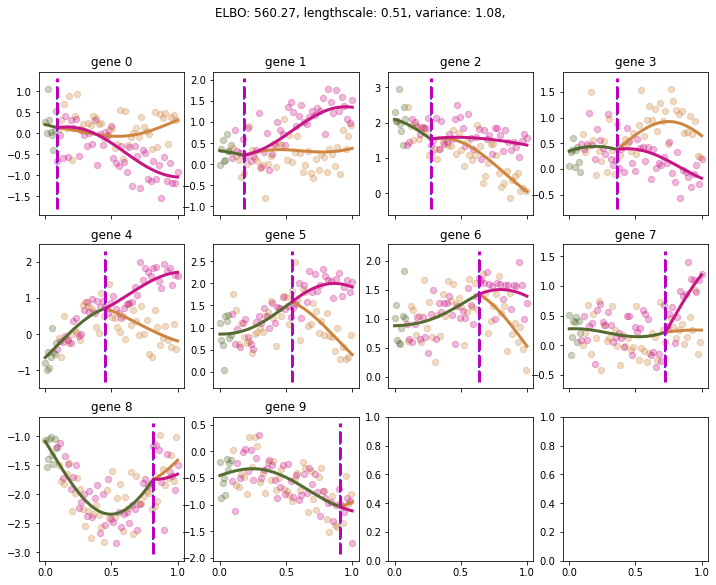

Slicing for gene 0
Uninformative until idx: 80


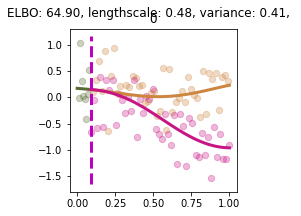

Slicing for gene 1
Uninformative until idx: 80


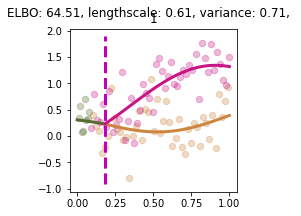

Slicing for gene 2
Uninformative until idx: 80


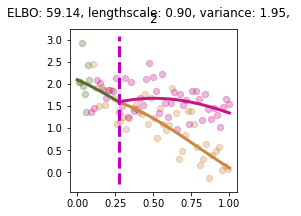

Slicing for gene 3
Uninformative until idx: 80


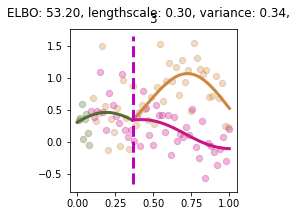

Slicing for gene 4
Uninformative until idx: 80


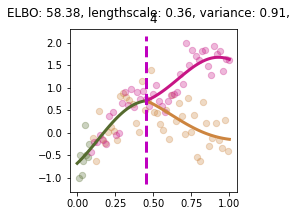

Slicing for gene 5
Uninformative until idx: 80


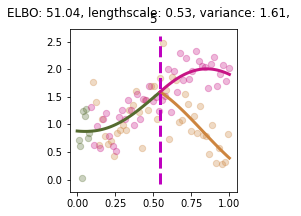

Slicing for gene 6
Uninformative until idx: 80


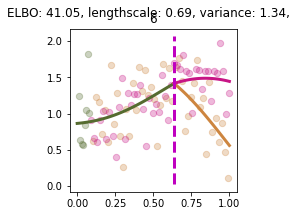

Slicing for gene 7
Uninformative until idx: 80


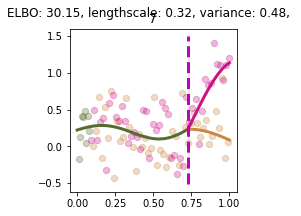

Slicing for gene 8
Uninformative until idx: 80


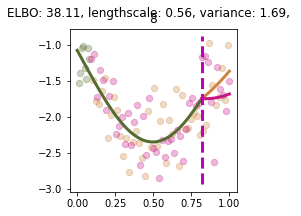

Slicing for gene 9
Uninformative until idx: 80


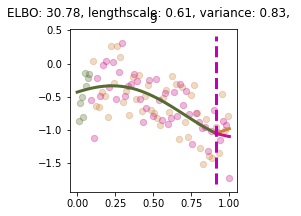

Processing sample 1
Uninformative until idx: 80


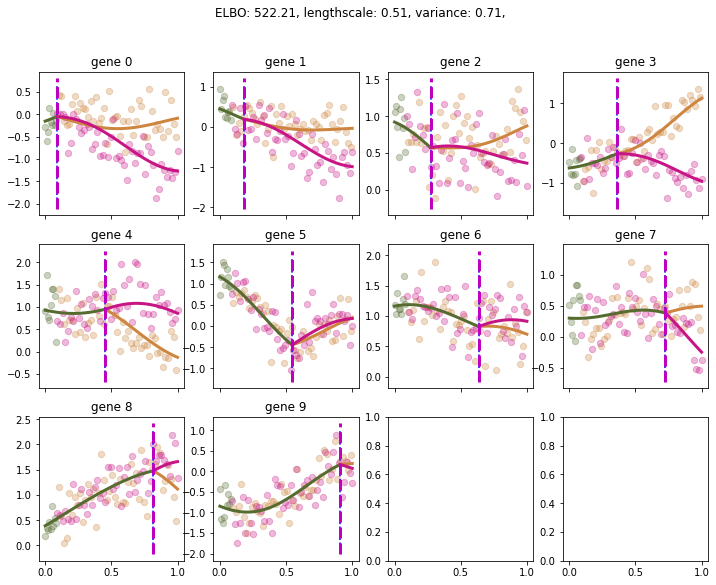

Slicing for gene 0
Uninformative until idx: 80


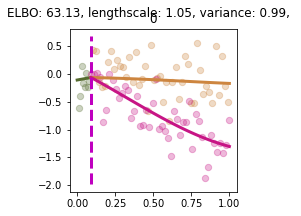

Slicing for gene 1
Uninformative until idx: 80


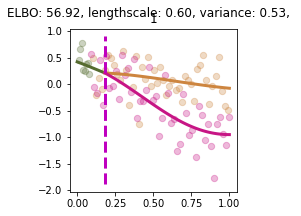

Slicing for gene 2
Uninformative until idx: 80


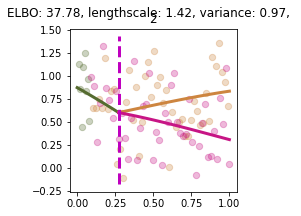

Slicing for gene 3
Uninformative until idx: 80


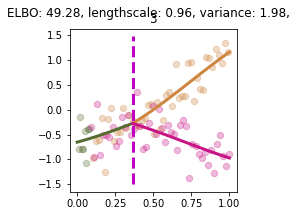

Slicing for gene 4
Uninformative until idx: 80


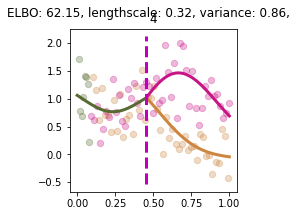

Slicing for gene 5
Uninformative until idx: 80


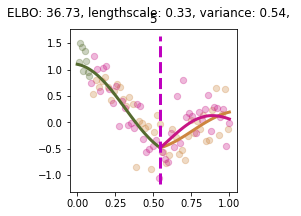

Slicing for gene 6
Uninformative until idx: 80


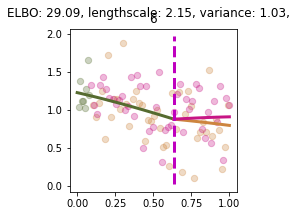

Slicing for gene 7
Uninformative until idx: 80


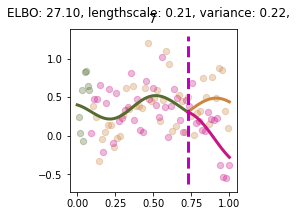

Slicing for gene 8
Uninformative until idx: 80


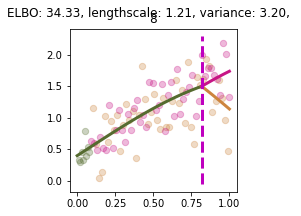

Slicing for gene 9
Uninformative until idx: 80


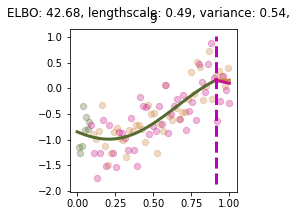

Processing sample 2
Uninformative until idx: 80


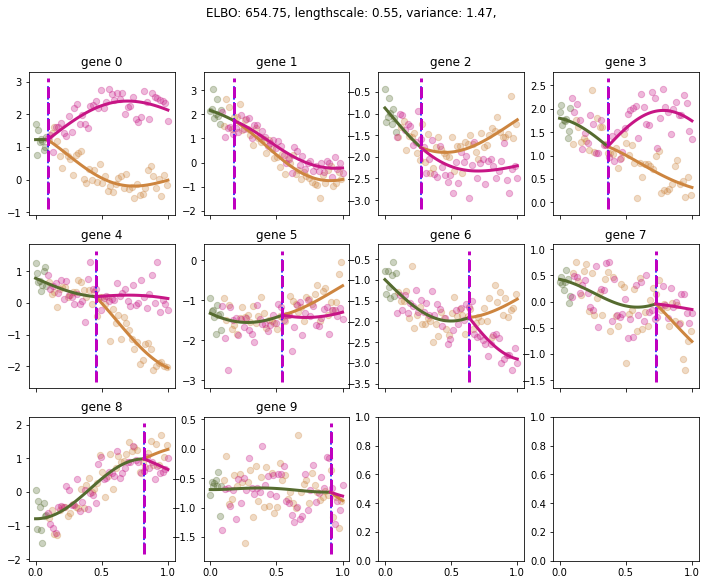

Slicing for gene 0
Uninformative until idx: 80


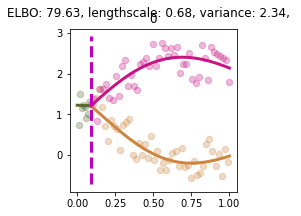

Slicing for gene 1
Uninformative until idx: 80


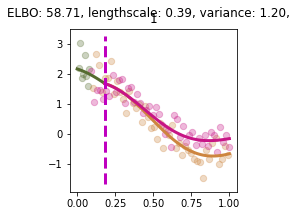

Slicing for gene 2
Uninformative until idx: 80


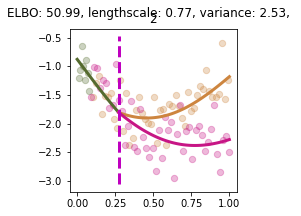

Slicing for gene 3
Uninformative until idx: 80


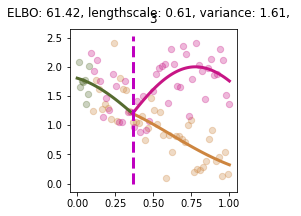

Slicing for gene 4
Uninformative until idx: 80


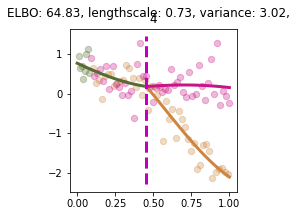

Slicing for gene 5
Uninformative until idx: 80


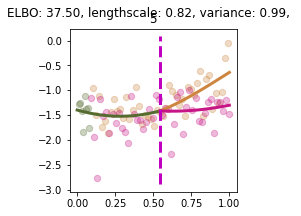

Slicing for gene 6
Uninformative until idx: 80


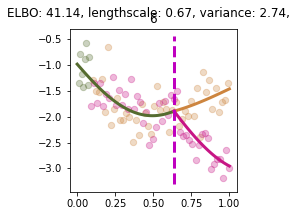

Slicing for gene 7
Uninformative until idx: 80


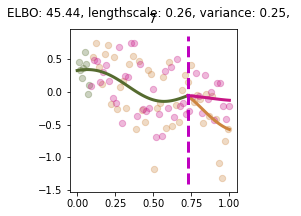

Slicing for gene 8
Uninformative until idx: 80


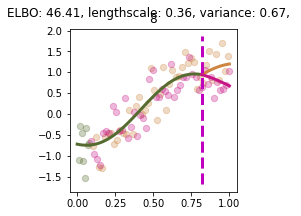

Slicing for gene 9
Uninformative until idx: 80


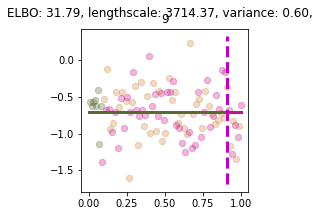

Processing sample 3
Uninformative until idx: 80


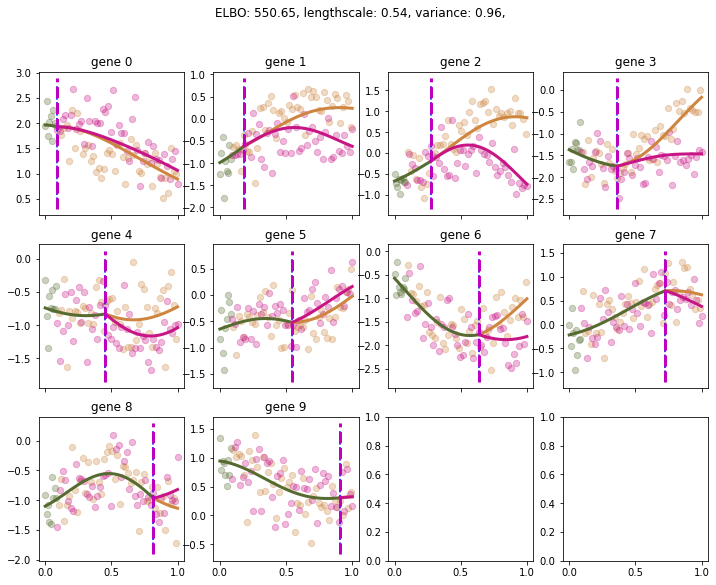

Slicing for gene 0
Uninformative until idx: 80


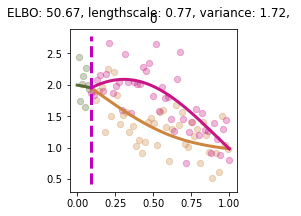

Slicing for gene 1
Uninformative until idx: 80


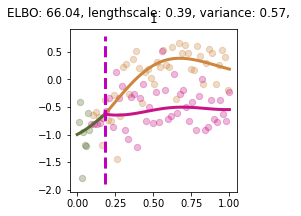

Slicing for gene 2
Uninformative until idx: 80


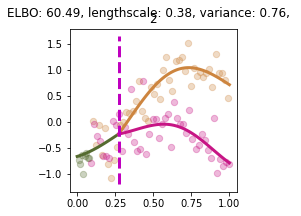

Slicing for gene 3
Uninformative until idx: 80


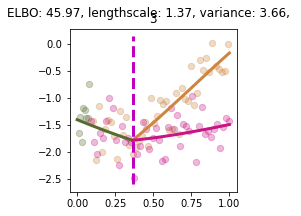

Slicing for gene 4
Uninformative until idx: 80


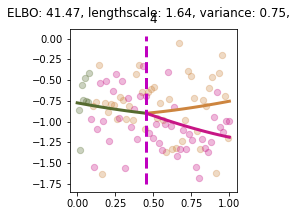

Slicing for gene 5
Uninformative until idx: 80


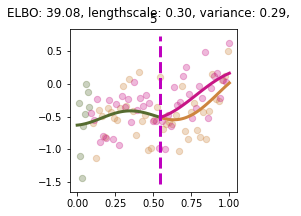

Slicing for gene 6
Uninformative until idx: 80


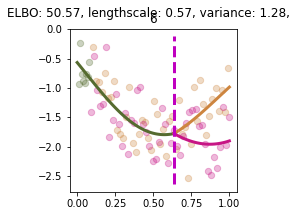

Slicing for gene 7
Uninformative until idx: 80


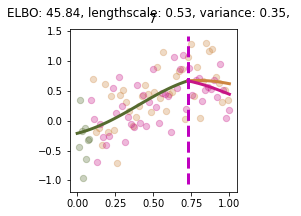

Slicing for gene 8
Uninformative until idx: 80


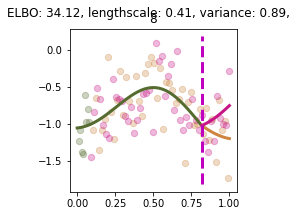

Slicing for gene 9
Uninformative until idx: 80


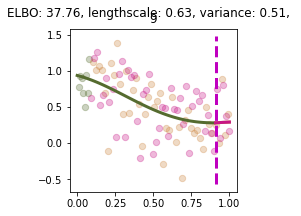

Processing sample 4
Uninformative until idx: 80


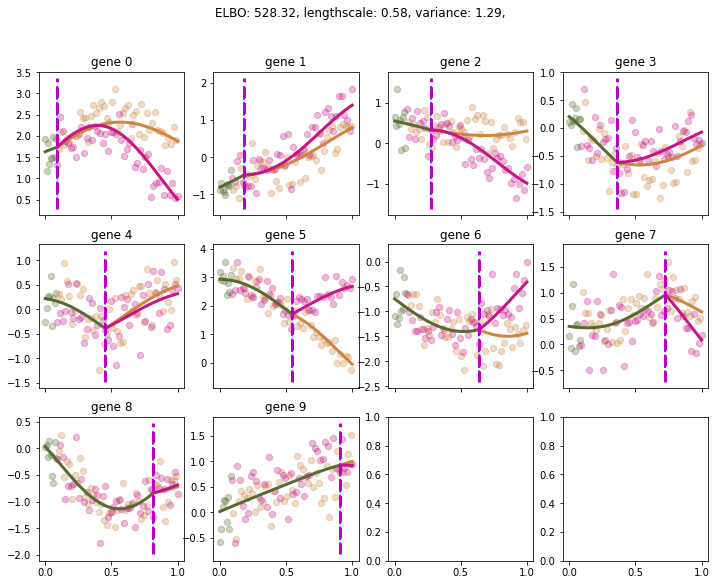

Slicing for gene 0
Uninformative until idx: 80


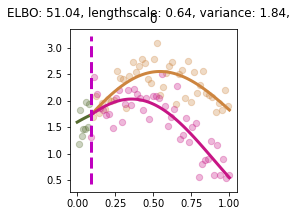

Slicing for gene 1
Uninformative until idx: 80


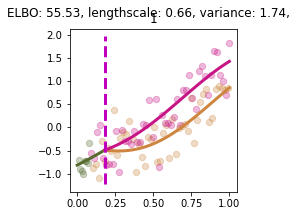

Slicing for gene 2
Uninformative until idx: 80


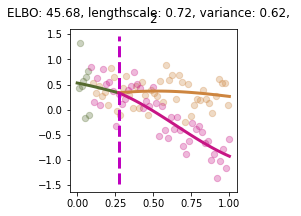

Slicing for gene 3
Uninformative until idx: 80


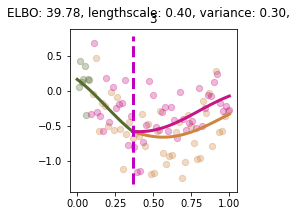

Slicing for gene 4
Uninformative until idx: 80


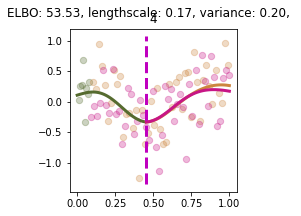

Slicing for gene 5
Uninformative until idx: 80


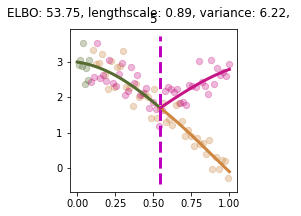

Slicing for gene 6
Uninformative until idx: 80


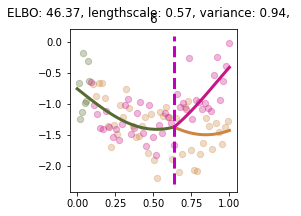

Slicing for gene 7
Uninformative until idx: 80


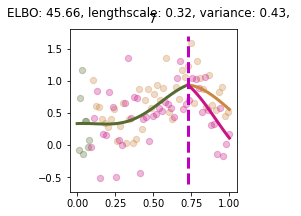

Slicing for gene 8
Uninformative until idx: 80


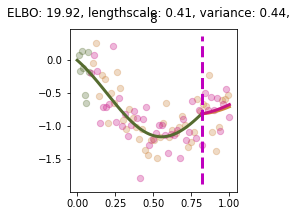

Slicing for gene 9
Uninformative until idx: 80


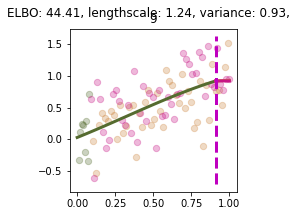

Processing sample 5
Uninformative until idx: 80


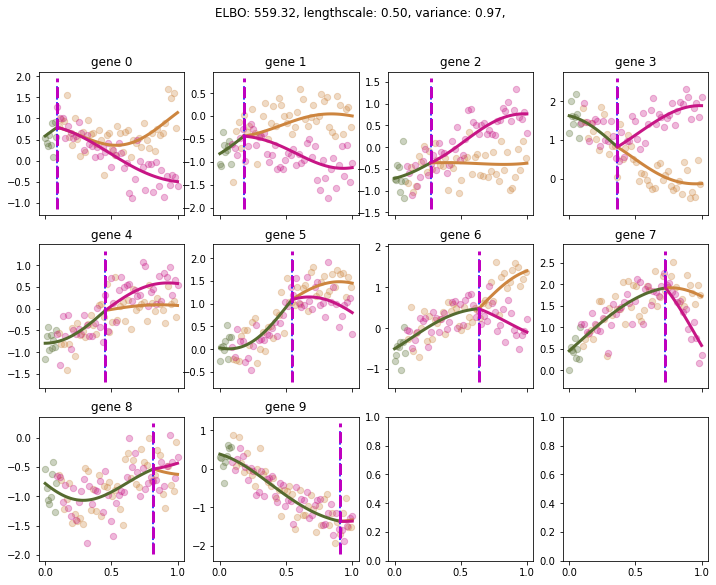

Slicing for gene 0
Uninformative until idx: 80


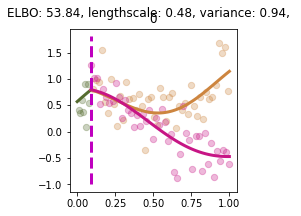

Slicing for gene 1
Uninformative until idx: 80


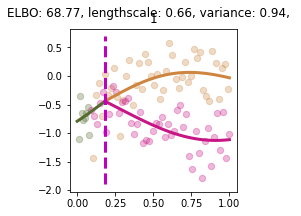

Slicing for gene 2
Uninformative until idx: 80


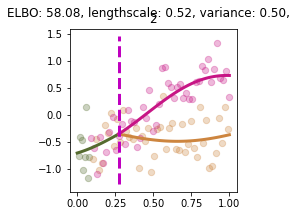

Slicing for gene 3
Uninformative until idx: 80


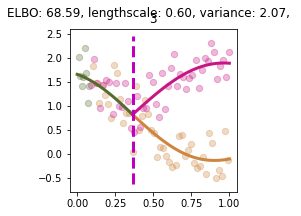

Slicing for gene 4
Uninformative until idx: 80


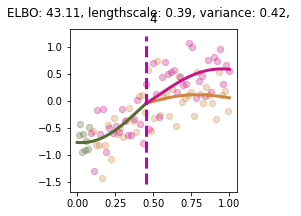

Slicing for gene 5
Uninformative until idx: 80


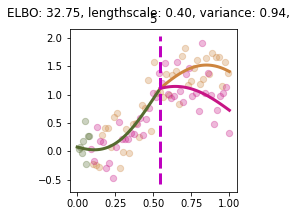

Slicing for gene 6
Uninformative until idx: 80


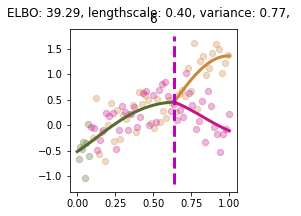

Slicing for gene 7
Uninformative until idx: 80


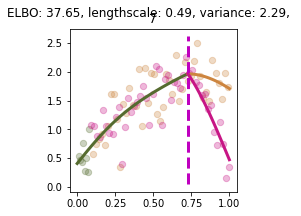

Slicing for gene 8
Uninformative until idx: 80


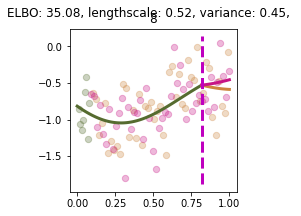

Slicing for gene 9
Uninformative until idx: 80


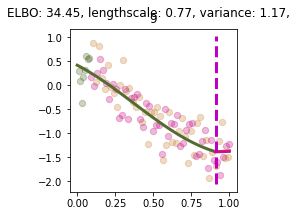

Processing sample 6
Uninformative until idx: 80


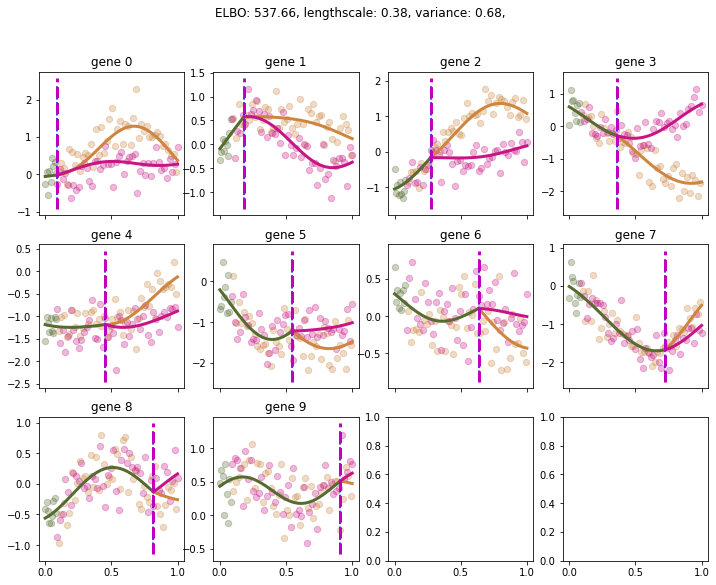

Slicing for gene 0
Uninformative until idx: 80


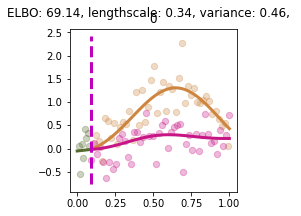

Slicing for gene 1
Uninformative until idx: 80


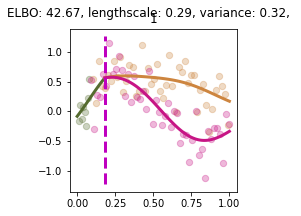

Slicing for gene 2
Uninformative until idx: 80


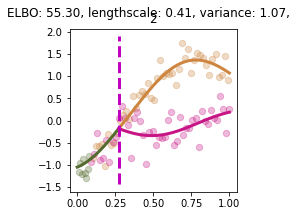

Slicing for gene 3
Uninformative until idx: 80


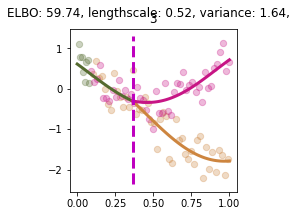

Slicing for gene 4
Uninformative until idx: 80


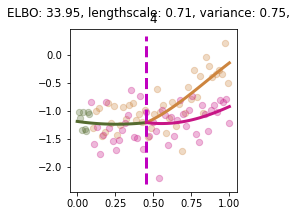

Slicing for gene 5
Uninformative until idx: 80


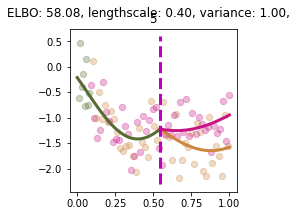

Slicing for gene 6
Uninformative until idx: 80


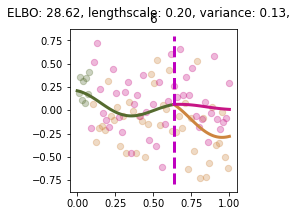

Slicing for gene 7
Uninformative until idx: 80


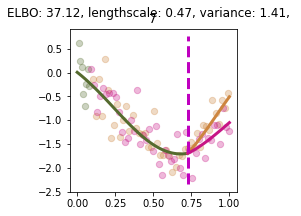

Slicing for gene 8
Uninformative until idx: 80


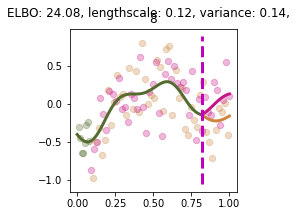

Slicing for gene 9
Uninformative until idx: 80


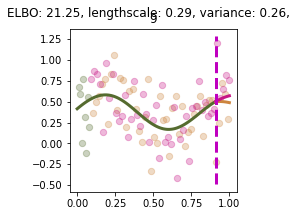

Processing sample 7
Uninformative until idx: 80


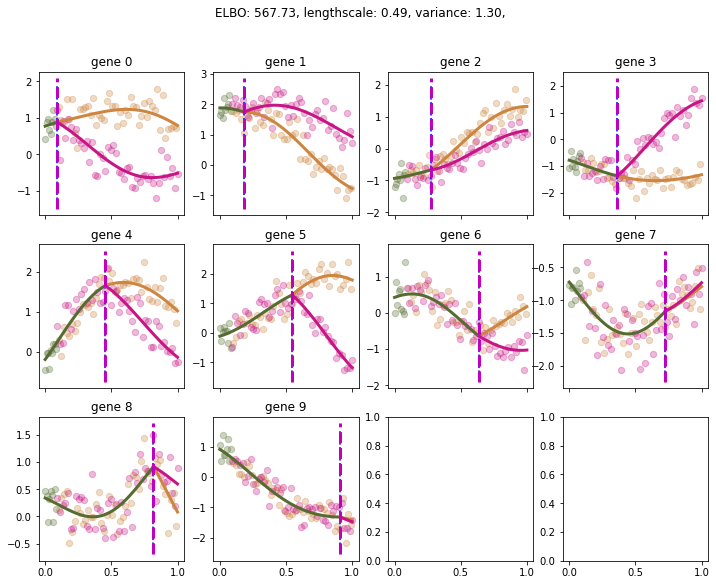

Slicing for gene 0
Uninformative until idx: 80


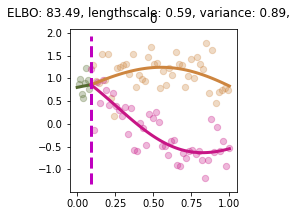

Slicing for gene 1
Uninformative until idx: 80


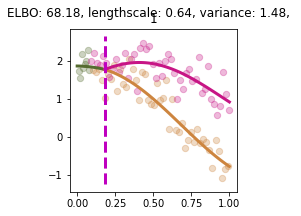

Slicing for gene 2
Uninformative until idx: 80


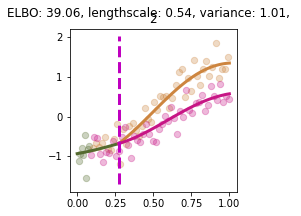

Slicing for gene 3
Uninformative until idx: 80


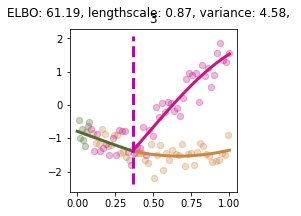

Slicing for gene 4
Uninformative until idx: 80


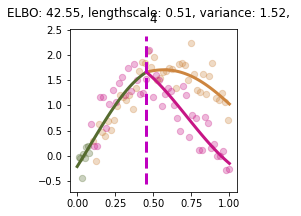

Slicing for gene 5
Uninformative until idx: 80


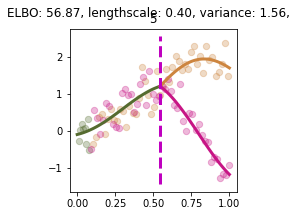

Slicing for gene 6
Uninformative until idx: 80


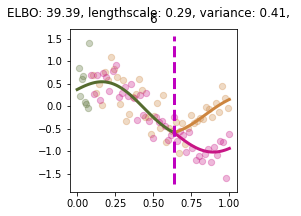

Slicing for gene 7
Uninformative until idx: 80


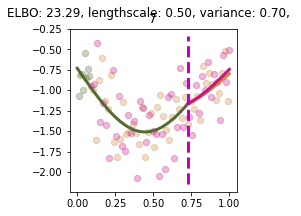

Slicing for gene 8
Uninformative until idx: 80


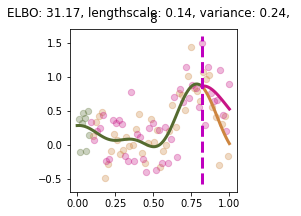

Slicing for gene 9
Uninformative until idx: 80


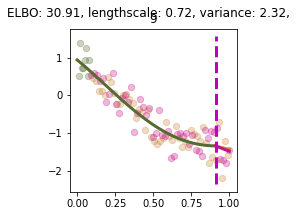

Processing sample 8
Uninformative until idx: 80


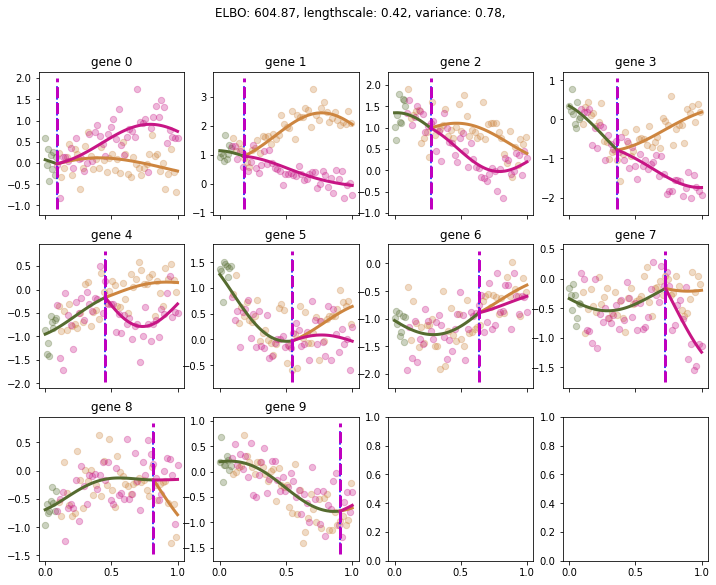

Slicing for gene 0
Uninformative until idx: 80


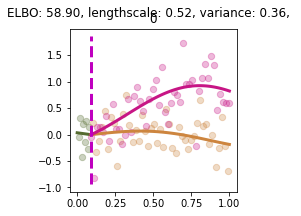

Slicing for gene 1
Uninformative until idx: 80


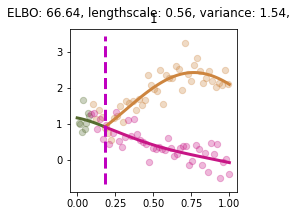

Slicing for gene 2
Uninformative until idx: 80


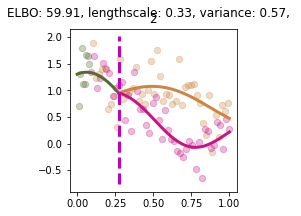

Slicing for gene 3
Uninformative until idx: 80


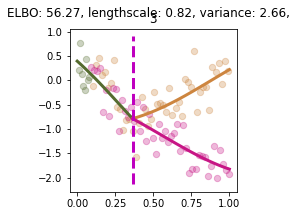

Slicing for gene 4
Uninformative until idx: 80


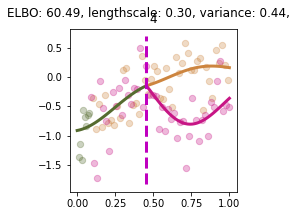

Slicing for gene 5
Uninformative until idx: 80


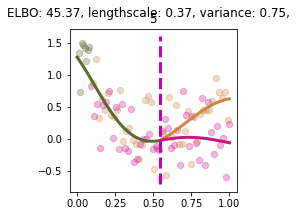

Slicing for gene 6
Uninformative until idx: 80


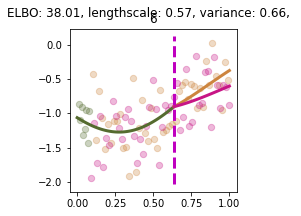

Slicing for gene 7
Uninformative until idx: 80


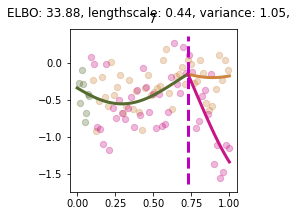

Slicing for gene 8
Uninformative until idx: 80


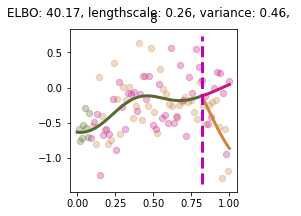

Slicing for gene 9
Uninformative until idx: 80


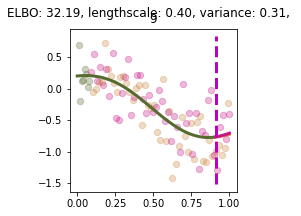

Processing sample 9
Uninformative until idx: 80


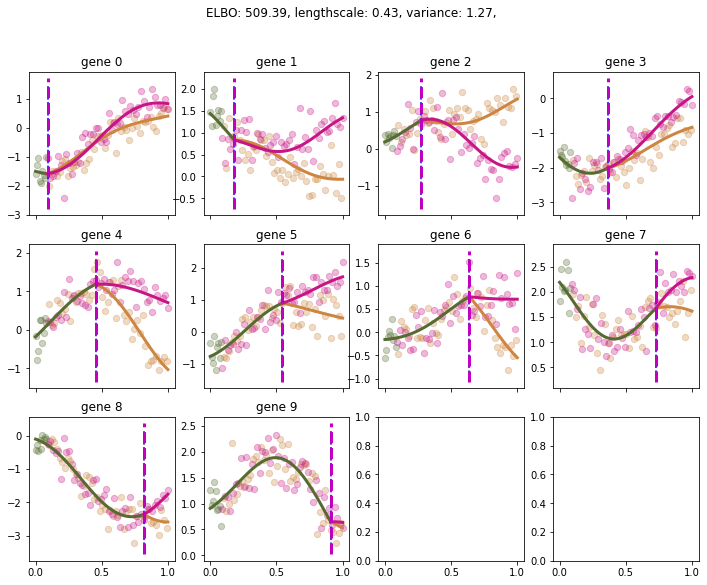

Slicing for gene 0
Uninformative until idx: 80


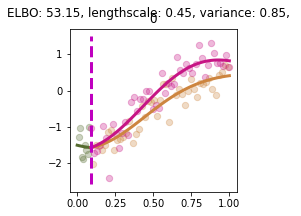

Slicing for gene 1
Uninformative until idx: 80


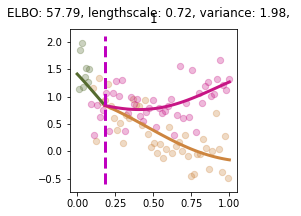

Slicing for gene 2
Uninformative until idx: 80


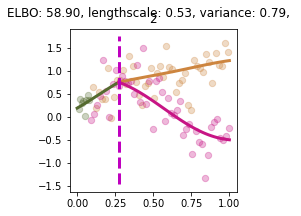

Slicing for gene 3
Uninformative until idx: 80


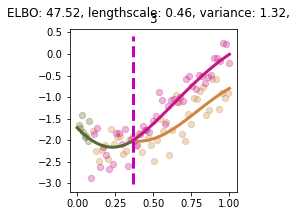

Slicing for gene 4
Uninformative until idx: 80


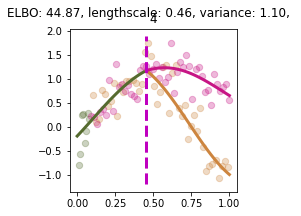

Slicing for gene 5
Uninformative until idx: 80


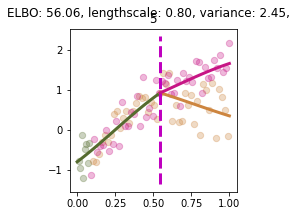

Slicing for gene 6
Uninformative until idx: 80


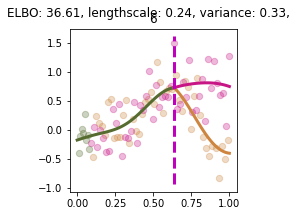

Slicing for gene 7
Uninformative until idx: 80


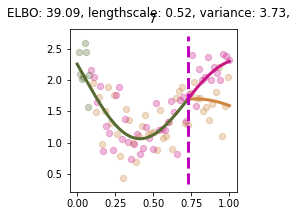

Slicing for gene 8
Uninformative until idx: 80


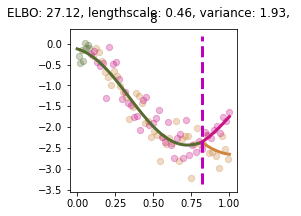

Slicing for gene 9
Uninformative until idx: 80


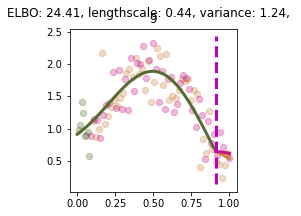

In [9]:
from MMBGP.training_helpers import fixed_bps


NOISE = 0.1
LENGTHSCALE = 0.5

NUM_SAMPLES = 10
TRUE_BPS = [i/11 for i in range(1, 11, 1)]


HIGH_PRIOR_CONFIDENCE = 0.8

dummy_model = get_assigngp_with_target_bps(
    TRUE_BPS, 
    lengthscale=LENGTHSCALE, 
    noise_variance=NOISE,
)
synthetic_noisy_data = get_synthetic_noisy_branched_data(
    dummy_model, 
    num_samples=NUM_SAMPLES, 
    x_pts=100,
)


LOW_PRIOR_CONFIDENCE = 0.8
UNINFORMATIVE_UNTIL = 0.8

funky_prior_results: List[Result] = []

for i, data in enumerate(synthetic_noisy_data):
    print(f"Processing sample {i}")
    
    #
    # MMBGP
    #
    mmbgp = construct_assigngp_model(
        gene_expression=data,
        phi_constructor=FunkyPrior(
            data,
            informative_prior_confidence=HIGH_PRIOR_CONFIDENCE, 
            uninformative_until=UNINFORMATIVE_UNTIL,
        ),
        initial_branching_points=TRUE_BPS,  # We start at the true locations
    )
    # And ensure we don't learn - fix BPs and switch to the simple Scipy optimiser
    mmbgp = fixed_bps(mmbgp)
    
    optimiser = ScipyOptimiser()
    try:
        trained_mmbgp = optimiser.train(mmbgp)
    except Exception as ex:
        print(f"Error in training: {ex}")
        trained_mmbgp = mmbgp
    
    plot_model_snapshot(trained_mmbgp, genes=data, alpha=0.3)
    plt.show()
    
    #
    # BGPs
    #
    bgps = []

    for i in range(data.num_genes):
        print(f"Slicing for gene {i}")
    
        sliced_data = GeneExpressionData(
            t=data.t,
            Y=data.Y[:, i].reshape(-1, 1),
            state=data.state,
            gene_labels=[f"{i}"]
        )
   
        bgp = construct_assigngp_model(
            gene_expression=sliced_data,
            phi_constructor=FunkyPrior(
                sliced_data,
                informative_prior_confidence=HIGH_PRIOR_CONFIDENCE, 
                uninformative_until=UNINFORMATIVE_UNTIL,
            ),
            initial_branching_points=[TRUE_BPS[i]],  # Initialise to true locations
        )
        fixed_bps(bgp)  # And don't learn BPs any further
        optimiser = ScipyOptimiser()
        try:
            trained_bgp = optimiser.train(bgp)
        except Exception as ex:
            print(f"Error in training: {ex}")
            trained_bgp = bgp
            
        plot_model_snapshot(trained_bgp, genes=sliced_data, alpha=0.3)
        plt.show()
    
        bgps.append(trained_bgp)
    
    result = Result(
        data=data,
        true_bps=np.array(TRUE_BPS),
        mmbgp=trained_mmbgp,
        bgps=bgps,
    )
    funky_prior_results.append(result)

In [10]:
funky_prior_df = convert_results_to_df(funky_prior_results, inconsistency_threshold=0.6)
funky_prior_df.head(30)

,sample_id,mmbgp_bp_rmse,bgp_bp_rmse,inconsistent_branches,inconsistent_all,mean_mmbgp_correct_labels,mean_bgp_correct_labels
0,0,9.813078e-18,9.813078e-18,22,26,95.3,91.3
1,1,9.813078e-18,9.813078e-18,24,26,94.4,91.5
2,2,9.813078e-18,9.813078e-18,18,21,99.6,93.8
3,3,9.813078e-18,9.813078e-18,26,30,95.2,91.3
4,4,9.813078e-18,9.813078e-18,23,26,94.7,90.3
5,5,9.813078e-18,9.813078e-18,19,20,97.6,93.0
6,6,9.813078e-18,9.813078e-18,18,19,97.2,92.7
7,7,9.813078e-18,9.813078e-18,16,19,99.3,95.1
8,8,9.813078e-18,9.813078e-18,27,30,99.2,92.6
9,9,9.813078e-18,9.813078e-18,31,35,94.3,90.1


In [11]:
funky_prior_df.describe()

,sample_id,mmbgp_bp_rmse,bgp_bp_rmse,inconsistent_branches,inconsistent_all,mean_mmbgp_correct_labels,mean_bgp_correct_labels
count,10.00000,1.000000e+01,1.000000e+01,10.000000,10.000000,10.000000,10.000000
mean,4.50000,9.813078e-18,9.813078e-18,22.400000,25.200000,96.680000,92.170000
std,3.02765,1.624087e-33,1.624087e-33,4.742245,5.432413,2.153447,1.568474
min,0.00000,9.813078e-18,9.813078e-18,16.000000,19.000000,94.300000,90.100000
25%,2.25000,9.813078e-18,9.813078e-18,18.250000,20.250000,94.825000,91.300000
50%,4.50000,9.813078e-18,9.813078e-18,22.500000,26.000000,96.250000,92.050000
75%,6.75000,9.813078e-18,9.813078e-18,25.500000,29.000000,98.800000,92.925000
max,9.00000,9.813078e-18,9.813078e-18,31.000000,35.000000,99.600000,95.100000


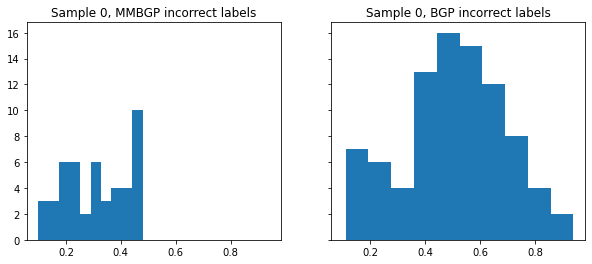

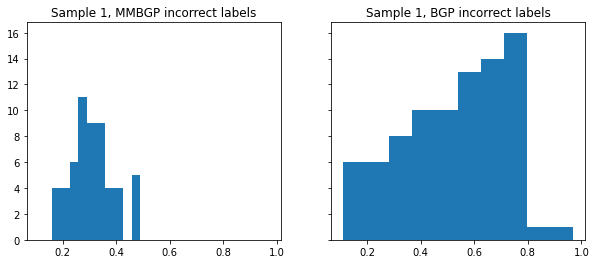

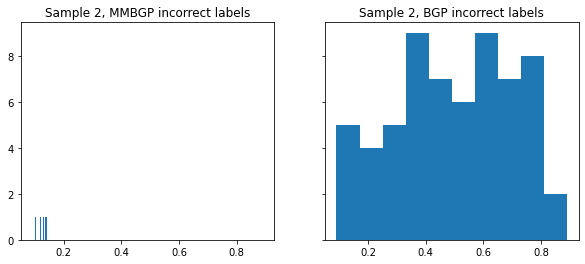

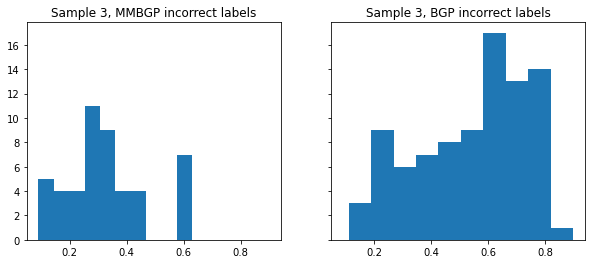

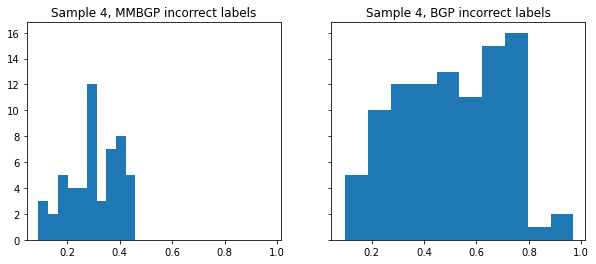

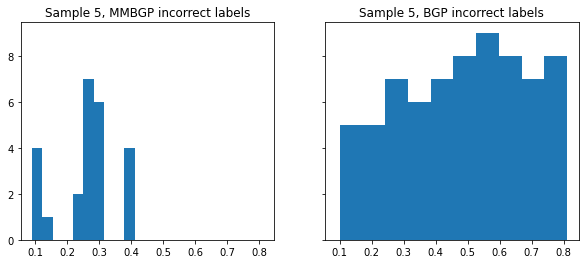

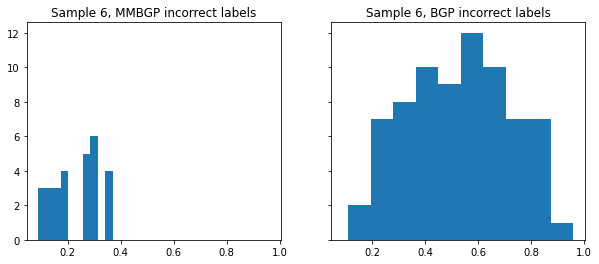

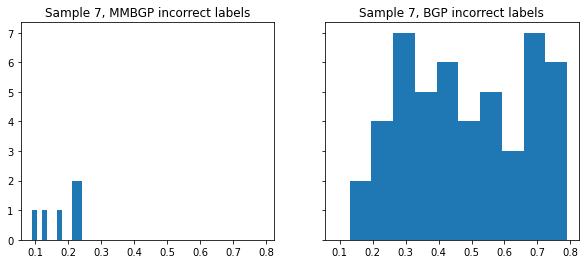

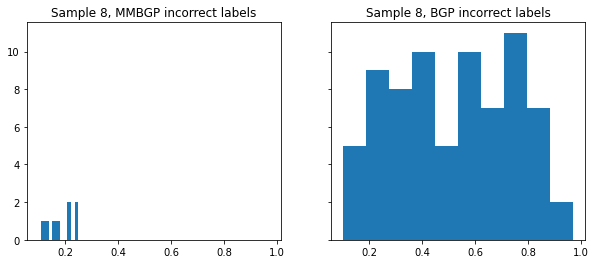

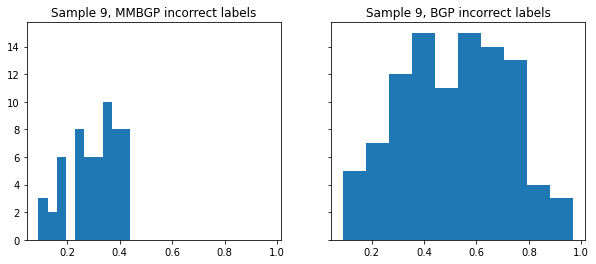

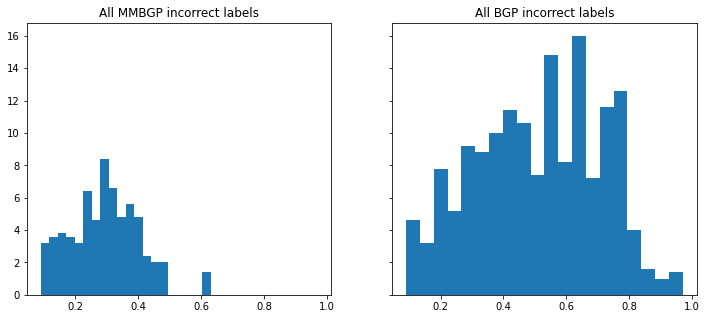

In [61]:
plot_incorrect_label_histograms(funky_prior_results)

In [33]:
pdf_table = funky_prior_df.copy()
pdf_table["mBGP"] = pdf_table["mean_mmbgp_correct_labels"]
pdf_table["BGP"] = pdf_table["mean_bgp_correct_labels"]
pdf_table = pdf_table[["mBGP", "BGP"]]
table = pdf_table.describe().to_latex()

In [34]:
print(table)

\begin{tabular}{lrr}
\toprule
{} &       mBGP &        BGP \\
\midrule
count &  10.000000 &  10.000000 \\
mean  &  96.680000 &  92.170000 \\
std   &   2.153447 &   1.568474 \\
min   &  94.300000 &  90.100000 \\
25\%   &  94.825000 &  91.300000 \\
50\%   &  96.250000 &  92.050000 \\
75\%   &  98.800000 &  92.925000 \\
max   &  99.600000 &  95.100000 \\
\bottomrule
\end{tabular}



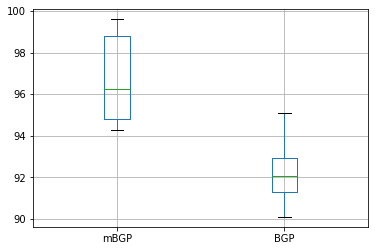

In [41]:
pdf_table.boxplot()
plt.savefig("correct-labels-no-bp-learning.png")

In [49]:
incorrect_mbgp_ptimes, incorrect_bgp_ptimes = get_incorrect_pseudotime_labels(funky_prior_results)

In [62]:
pdf_table.describe()

,mBGP,BGP
count,10.000000,10.000000
mean,96.680000,92.170000
std,2.153447,1.568474
min,94.300000,90.100000
25%,94.825000,91.300000
50%,96.250000,92.050000
75%,98.800000,92.925000
max,99.600000,95.100000


In [63]:
pdf_table.mean()

mBGP    96.68
BGP     92.17
dtype: float64

In [64]:
pdf_table.sem()

mBGP    0.680980
BGP     0.495995
dtype: float64

# Some extracts for the paper


In [65]:
per_sample_results = funky_prior_df.to_latex()

In [67]:
print(per_sample_results)

\begin{tabular}{lrrrrrrr}
\toprule
{} &  sample\_id &  mmbgp\_bp\_rmse &   bgp\_bp\_rmse &  inconsistent\_branches &  inconsistent\_all &  mean\_mmbgp\_correct\_labels &  mean\_bgp\_correct\_labels \\
\midrule
0 &          0 &   9.813078e-18 &  9.813078e-18 &                     22 &                26 &                       95.3 &                     91.3 \\
1 &          1 &   9.813078e-18 &  9.813078e-18 &                     24 &                26 &                       94.4 &                     91.5 \\
2 &          2 &   9.813078e-18 &  9.813078e-18 &                     18 &                21 &                       99.6 &                     93.8 \\
3 &          3 &   9.813078e-18 &  9.813078e-18 &                     26 &                30 &                       95.2 &                     91.3 \\
4 &          4 &   9.813078e-18 &  9.813078e-18 &                     23 &                26 &                       94.7 &                     90.3 \\
5 &          5 &   9.813078e-1